  CustomerID  TotalQuantity  TotalSpent  PurchaseFrequency
0      C0001             12     1391.67                  5
1      C0002             10      835.68                  4
2      C0003             14      782.83                  4
3      C0004             23     1925.09                  8
4      C0005              7      874.81                  3


C:\Users\hp\anaconda31\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\hp\anaconda31\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\hp\anaconda31\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\hp\anaconda31\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment varia

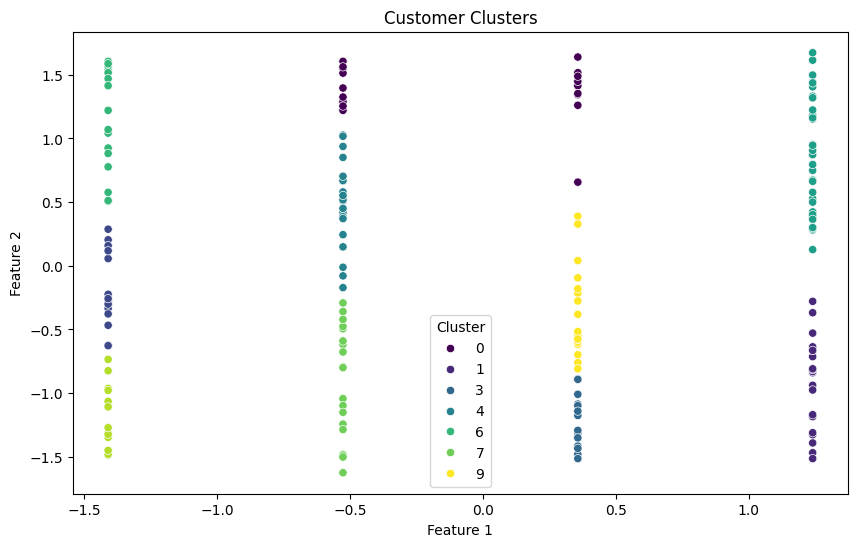

Clustering completed. Results saved to Clustering_Metrics.csv and Clustered_Customers.csv.


In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Aggregate transaction data
transaction_agg = transactions.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'Price': 'sum',
    'TransactionID': 'count'
}).reset_index()

# Renaming the columns
transaction_agg = transaction_agg.rename(columns={
    'Quantity': 'TotalQuantity',
    'Price': 'TotalSpent',
    'TransactionID': 'PurchaseFrequency'
})

print(transaction_agg.head())


# Merge with customer profile data
customer_data = customers.merge(transaction_agg, on='CustomerID', how='left').fillna(0)

# Select features for clustering
# Encode 'Region' as numerical values
label_encoder = LabelEncoder()
customer_data['RegionEncoded'] = label_encoder.fit_transform(customer_data['Region'])

# Convert 'SignupDate' to days since the signup (you can adjust this based on the current date)
customer_data['DaysSinceSignup'] = (pd.to_datetime('today') - pd.to_datetime(customer_data['SignupDate'])).dt.days

# Select features for clustering
features = customer_data[['RegionEncoded', 'DaysSinceSignup']]



# Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Clustering and evaluation
cluster_results = []
for n_clusters in range(2, 11):
    # KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(scaled_features)

    # Calculate Davies-Bouldin Index
    db_index = davies_bouldin_score(scaled_features, labels)
    
    # Calculate Silhouette Score
    silhouette_avg = silhouette_score(scaled_features, labels)

    # Save results
    cluster_results.append({
        'n_clusters': n_clusters,
        'db_index': db_index,
        'silhouette_score': silhouette_avg
    })

# Convert results to DataFrame
results_df = pd.DataFrame(cluster_results)

# Best cluster based on DB Index
best_cluster = results_df.loc[results_df['db_index'].idxmin()]

# Final clustering with the best number of clusters
best_n_clusters = int(best_cluster['n_clusters'])
final_kmeans = KMeans(n_clusters=best_n_clusters, random_state=42)
final_labels = final_kmeans.fit_predict(scaled_features)

# Add cluster labels to the original data
customer_data['Cluster'] = final_labels

# Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x=scaled_features[:, 0], y=scaled_features[:, 1], hue=final_labels, palette='viridis')
plt.title('Customer Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(title='Cluster')
plt.show()

# Save clustering metrics and results
results_df.to_csv('Clustering_Metrics.csv', index=False)
customer_data.to_csv('Clustered_Customers.csv', index=False)

print("Clustering completed. Results saved to Clustering_Metrics.csv and Clustered_Customers.csv.")